# Taller II: Implementing a simple ASR system using HMM

En este taller implementaremos un sistema de reconocimiento automatico de habla, utilizando modelos ocultos de markov. Para este taller se puede utilizar la libreria [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#customizing) de Python. Este taller será parte de la nota del proyecto de evaluación del primer corte. Así que se deberá entregar al finalizar la semana 5 junto con el desarrollo del proyecto de evaluación.

En este taller implementaremos un sistema de reconocimiento de habla de palabras aisladas. Esto quiere decir que hay una separación entre cada palabra pronunciada, y no se utilizará  habla fluida continua. La idea es implementar un sistema sencillo con un vocabulario limitado, para qu epuedan entender el principio de funcionamiento de estos sistemas. Para este taller deben seguir lso siguientes pasos:

1. Cree un diccionaro pequeño compuesto de alrededor de 20 palabras. Si desean incluir más palabras no hay problema.
2. Cada una de estas palabras dividalas en fonemas. Asigne a cada fonema un número para facilitar su identificación.
3. Grabé cada una de las palbaras de forma aislada. 
4. Para cada señal de voz grabada calcule el mel espectrograma utilizando 39 componentes (este es el estandar que usan los sistemas modernos).
5. Identifique las secciones del mel spectrograma que corresponden a cada fonema.
6. Modele la distribución de los vectores del Mel espectrograma para cada fonema, esto puede hacerlo usando GMM (Gaussian Mixture Models).
7. Calcule la matrix de probabilidades de transición utilizando el diccionario que ustedes crearón.
8. Implemente el modelo HMM.
9. Pruebe con los datos de entrenamiento si el modelo produce la secuencia de fonemas indicada.
10. Genere un nuevo conjunto de palabras (al menos 10) que se conformen con los fonemas presentes en su diccionario. A partir de la señal de voz de cada una de estas nuevas palabras, trate de predecir la palbara escrita utilizando el modelo implementado.

**NOTA:** Trate de Utilizar fonemas que tengan una única relación con letras (silabas) del alfabeto. Esto disminuirá la tasa de error del modelo.

1. Fecha -> /f/e/ch/a/
2. Libro -> /l/i/b/r/o
3. Lapiz -> /l/a/p/i/z
4. Correr -> /c/o/rr/e/r
5. Telefono -> /t/e/l/e/f/o/n/o
6. Puerta -> /p/u/e/r/t/a
7. Pantalla -> /p/a/n/t/a/ll/a
8. Ximena -> /x/i/m/e/n/a
9. Regla -> /r/e/g/l/a
10. Billetera -> /b/i/ll/e/t/e/r/a
11. Zapato -> /c/a/p/a/t/o
12. Jamón -> /j/a/m/o/n/
13. kiosko -> /k/i/o/s/k/o
14. baloncesto -> /b/a/l/o/n/c/e/s/t/o
15. murcielago -> /m/u/r/c/i/e/l/a/g/o
16. muchacho -> /m/u/c/h/a/c/h/o
17. ahijado -> /a/ /i/j/a/d/o
18. Terremoto -> /t/e/rr/e/m/o/t/o
19. Llorar -> /ll/o/r/a/r
20. espantapajaro -> /e/s/p/a/n/t/a/p/a/j/a/r/o

## Clasificacion de fonemas:

1. /a/ -> a -> 1
2. /b/ -> b,v,w(depende) -> 2
3. /c/ -> c(ante e,i),z(ante a,o,u) -> 3
4. /ch/ -> ch -> 4
5. /d/ -> d ->5
6. /e/ -> e -> 6
7. /f/ -> f -> 8
9. /g/ -> g (ante a,o,u const), gu(ante e i) -> 9
10. // -> h -> 10
11. /i/ -> i,y -> 11
12. /j/ -> g(ante e,i) j(vocales) -> 12
13. /k/ -> c (ante a, o, u o consontante) qu (ante e, i), k -> 13
14. /l/ -> l ->14
15. /ll/ -> ll ->15
16. /m/ -> m -> 16
17. /n/ -> n ->17
18. /ñ/ -> ñ -> 18
19. /o/ -> o -> 19
20. /p/ ->p ->20
21. /r/-> r (arena) -> 21
22. /rr/-> (arriba) -> 22
23./s/ -> s -> 23
24. /t/ -> t -> 24
25. /u/ -> u -> 25
26. /x/ -> x -> 26
27. /y/ -> y -> 27




In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy as sc
from scipy import signal
from scipy.fft import fftshift

import librosa
import librosa.display

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import soundfile as sf
import os

In [41]:
fs = 8000 # Numero de muestras por segundo
nBits = 16 # Numero de bits por muestra del audio
ID = -1
seconds = 5 # Duracion de la grabacion
Nfft = 512
fm = np.arange(0, Nfft / 4) * fs / Nfft

In [10]:
nombres = os.listdir('./utils/sounds/')
nombres

['sound1.wav',
 'sound10.wav',
 'sound2.wav',
 'sound3.wav',
 'sound4.wav',
 'sound5.wav',
 'sound6.wav',
 'sound7.wav',
 'sound8.wav',
 'sound9.wav']

In [36]:
def getAudios(nombres):
    audios = []
    for i in nombres:
        y_aux, fs_aux = sf.read('./utils/sounds/' + i)
        y_aux = y_aux[:,0]
        y = ((1/np.std(y_aux))*y_aux).reshape(len(y_aux))
        audios.append(y)
    return audios

In [49]:
def getMelSpectogram(audios,fs,Nfft):
    spectograms = []
    for i in audios:
        Sm = librosa.feature.melspectrogram(y=i, sr=fs, n_fft=Nfft, n_mels = 39)
        spectograms.append(Sm)
    return spectograms

In [40]:
audios = getAudios(nombres)

In [50]:
Spectograms = getMelSpectogram(audios,fs,Nfft)

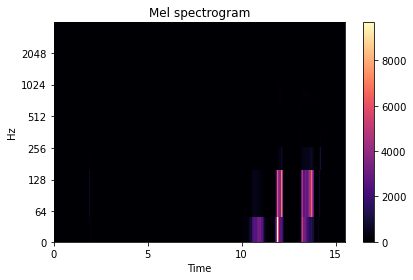

In [54]:
# Graficando diversos espectogramas
Sm = Spectograms[9]
fig=plt.figure()
#librosa.display.specshow(Sm,y_axis='mel',x_axis='time')
librosa.display.specshow(Sm, sr=fs, hop_length=Nfft, x_axis='time', y_axis='log')
plt.colorbar() #Confirmar unidad
plt.title("Mel spectrogram")
plt.tight_layout()

In [55]:
def getVectorErrores(Spectograms):
    DSms = []
    for i in Spectograms:
        D_Sm = np.sqrt(np.sum((i[:,1:] - i[:,0:-1])**2,axis=0))
        DSms.append(D_Sm)
    return DSms

In [56]:
DSms = getVectorErrores(Spectograms)

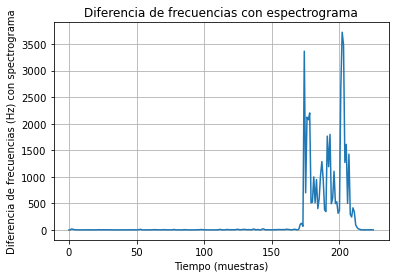

In [60]:
D_Sw = DSms[8]
fig = plt.figure()
plt.grid(True)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia de frecuencias (Hz) con spectrograma") # REVISAR
plt.title("Diferencia de frecuencias con espectrograma")
plt.plot(D_Sw);

In [65]:
aux = D_Sw[D_Sw > 100]

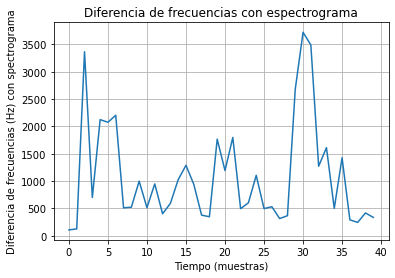

In [66]:
fig = plt.figure()
plt.grid(True)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia de frecuencias (Hz) con spectrograma") # REVISAR
plt.title("Diferencia de frecuencias con espectrograma")
plt.plot(aux);

In [69]:
#aux2 = aux/6
muestra = np.arange(0,len(aux) + 1,len(aux)/6)
muestra

array([ 0.        ,  6.66666667, 13.33333333, 20.        , 26.66666667,
       33.33333333, 40.        ])

In [1]:
# Diccionario de fonemas a numero
# Basados en: https://www.livingspanish.com/correspondencia-fonetica-grafia.htm
dic_fon = {"/a/":1, "/b/":2, "/c/":3, "/ch/":4, "/d/":5,
           "/e/":6, "/f/":7, "/g/":8, "//":9, "/i/":10,
           "/j/":11, "/k/":12, "/l/":13, "/m/":14, "/n/":15,
           "/ñ/":16, "/o/":17, "/p/":18, "/rr/":19, "/s/":20,
           "/t/":21, "/u/":22, "/x/":23, "/y/":24, "/ll/":25,
           "/r/":26
}
# El de h es sin espacio
#/rr/ y /r/ están diferenciado

In [ ]:
# falta desde "ll"
def get_fonemas(p):
    """
    Devuelve una lista con los fonemas de la palara p
    """
    fonemas = []
    vocales = {'a','e','i','o','u'}
    for i in range(len(p)):
        # Fonemas literales iguales a su letra
        if p[i] in {"a","b","d","e","f","i","j",
                    "k","m","n","ñ","o","p",
                    "s","t","u","x","y"}:
            fonemas.append(dic_fon["/"+p[i]+"/"])
        elif p[i] == 'v' or p[i]=='w':
            fonemas.append(dic_fon["/b/"])
        elif i < len(p-1):
            # Para fonemas que dependen de letra de adelante
            if (p[i] == 'c' and p[i+1] in {'e','i'}) or (p[i] == "z" and p[i+1] in {'a','o','u'}):
                fonemas.append(dic_fon["/c/"])
            elif p[i] == "c" and p[i+1] == "h":
                fonemas.append(dic_fon["/ch/"])
            elif p[i] == "g" and ((p[i+1] in {'a','o','u'}) or (p[i+1] not in vocales)):
                fonemas.append(dic_fon["/g/"])
            elif (p[i] == "g" and  p[i+1] in {'e','i'}) or (p[i] == "j"):
                fonemas.append(dic_fon["/j/"])
            elif p[i] == "c" and ((p[i+1] in {'a','o','u'}) or (p[i+1] not in vocales)):
                fonemas.append(dic_fon["/k/"])
        elif i < (len(p)-2):
            # Para fonemas que dependen de dos letras adelante
            if p[i] == "q" and p[i+1]=="u" and p[i+2] in {"e","i"}:
                fonemas.append(dic_fon["/k/"])
        elif p[i] == "h":
            if ((i > 0 and p[i-1] != "c") or (i==0):
                fonemas.append(dic_fon["//"])